<a href="https://colab.research.google.com/github/Divyesh-Kanagavel/deep_learning--keras/blob/master/NN_Intro_AK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def f(x):
  return 3*x**2 - 4*x + 5

In [ ]:
f(3.0)

20.0

In [ ]:
xs = np.arange(-5,5,0.25)

In [ ]:
ys = f(xs)

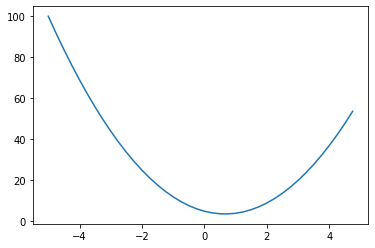

In [ ]:
plt.plot(xs,ys)

In [ ]:
class Value:
  def __init__(self,data,_children=(), _op='',label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda : None   # initially an empty function
    self._prev = set(_children)
    self._op = _op
    self.label=label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self,other):
    other=other if isinstance(other,Value) else Value(other)
    out =  Value(self.data+other.data, (self,other), '+')
    def _backward():
      self.grad += 1.0*out.grad
      other.grad += 1.0*out.grad
    out._backward = _backward
    return out

  def __radd__(self,other):
    return (self+other)

  def __sub__(self,other):
    return self + (-other)

    return out
  # a*2.0 is solved with checking the type of other, but 2.0 * a still throws an error - rmul instead of mul fixes this
  # rmul will swap the arguments and check if such an overloading exists.
  def __rmul__(self,other):
    return self*other

  def __mul__(self,other):
    other=other if isinstance(other,Value) else Value(other)
    out = Value(self.data*other.data, (self,other), '*')
    def _backward():
      self.grad += other.data*out.grad
      other.grad += self.data*out.grad
    out._backward = _backward
    return out

  def __neg__(self):
    return self * -1

  def __pow__(self,other):
    assert isinstance(other,(int,float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')
    def _backward():
      self.grad += other*(self.data**(other-1))*out.grad
    out._backward = _backward
    return out

  def __truediv__(self,other):
    return self*other**-1

  def exp(self):
    x = self.data
    t = math.exp(x)
    out = Value(t,(self,), 'exp')
    def _backward():
      self.grad+=t*out.grad
    out._backward = _backward
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
    out = Value(t, (self,),'tanh')
    def _backward():
      self.grad += (1-t**2)*out.grad
    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    self.grad=1
    for node in reversed(topo):
      node._backward()


In [ ]:
a = Value(2.0)
b = Value(3.0)
a**3


Value(data=8.0)

apart from addition and multiplication, one more operation is required for neural network operations. (Activation functions like tanh, sigmoid etc).
To do auto backprop , we need a function in Value class which can map the current grad to previous grad thereby propagating the chain rule useful for backprop.
for simple math operations like addition, multiplication, tanh, it is already known.
we now have the backward function per node in our neural network which will help us compute gradient of the children. But, we cannot be calling backward individually.so, we sort the neural network graph topologically and then call backward function in the reverse order from the output node o.

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f  }" % (n.label, n.data,n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


The micrograd is the class built on top : it works on scalar values. you can add functions which might be included in your neural networks like sigmoid etc.
Now , pytorch's autograd is similar to micrograd here but it works on tensors instead of scalar values.

In [ ]:
import torch

In [ ]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
# by default when you create tensors, they are assumed to be leaf nodes and requires_grad is set to False
#so, it is set to true
#also, by default the dtype is float32,by casting it to double, it is made float64

In [ ]:
o.backward()
print(f"Gradient of x1 : {x1.grad.item()}")
print(f"Gradient of w1 : {w1.grad.item()}")
print(f"Gradient of x2 : {x2.grad.item()}")
print(f"Gradient of w2 : {w2.grad.item()}")

Gradient of x1 : -1.5000003851533106
Gradient of w1 : 1.0000002567688737
Gradient of x2 : 0.5000001283844369
Gradient of w2 : 0.0


just as we built a micrograd which matches with api of pytorch(pytorch is efficient thanks to parallelization), we will build a neuron, layer and netork similar to how pytorch is built to handle

In [ ]:
import random

In [ ]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]



next step is the construction of layer -> since the neuron is already constructed.

In [ ]:
class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]


In [ ]:
class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [ ]:
n = MLP(3, [4, 4, 1])

an example where there are some sample inputs, outputs and loss function to make the neural network trainable.

In [ ]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


In [ ]:
ypred = [n(x) for x in xs]

In [ ]:
ypred

[Value(data=-0.16405911805550052),
 Value(data=0.05213921846862931),
 Value(data=-0.22770039968503053),
 Value(data=-0.17457404627170683)]

In [ ]:
loss  = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

In [ ]:
loss # loss function for the problem

Value(data=4.43810142818968)

In [ ]:
len(n.parameters())

41

In [ ]:
loss.backward()

In [ ]:
loss.grad


1

In [ ]:
n.layers[0].neurons[0].w[0].grad  # first weight of first neuron for first layer contributes to loss in the following way, ,meaning its increase decreases loss.

3.363820484088941

In [ ]:
#SGD : Backprop learning
#Gradient can be though of as vector in the direction of increased loss
#Gradient descent
for p in n.parameters():
  p.data += -0.01*p.grad


In [ ]:
ypred = [n(x) for x in xs]
loss  = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

In [ ]:
loss

Value(data=3.4970660684211)

In [ ]:
#let us do the same for some iterations to check if the loss function converges to zero and the ypred gets closer to ys
n = MLP(3, [4, 4, 1])
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

for i in range(50):
  #forward pass
  ypred = [n(x) for x in xs]
  loss  = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  #backprop
  # a subtle and important bug here, before every iteration of backprop, the grads for each parameter must be set to zero,else there will be higher step size and divergence
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  for p in n.parameters():
    p.data += -0.1*p.grad

  print(i, loss)


0 Value(data=7.00154478653654)
1 Value(data=2.547415143939822)
2 Value(data=2.3158042033642556)
3 Value(data=1.7836034804516105)
4 Value(data=0.4066239706984542)
5 Value(data=0.08853897943945072)
6 Value(data=0.061618721709753375)
7 Value(data=0.04773047761272176)
8 Value(data=0.03911979476381267)
9 Value(data=0.033221658177162536)
10 Value(data=0.028915258397032937)
11 Value(data=0.02562708123658486)
12 Value(data=0.023031396683457814)
13 Value(data=0.020928826066877723)
14 Value(data=0.01919021724178078)
15 Value(data=0.017728100558184814)
16 Value(data=0.016481065929752455)
17 Value(data=0.015404697921830947)
18 Value(data=0.014466059262765951)
19 Value(data=0.013640197746703223)
20 Value(data=0.012907858669473816)
21 Value(data=0.012253942811530433)
22 Value(data=0.011666440547892518)
23 Value(data=0.011135678655224683)
24 Value(data=0.010653777600071546)
25 Value(data=0.010214253630998645)
26 Value(data=0.009811722451750883)
27 Value(data=0.0094416754137844)
28 Value(data=0.009100

In [ ]:
ypred

[Value(data=0.981238774516687),
 Value(data=-0.954653394861624),
 Value(data=-0.9500572058171424),
 Value(data=0.980356985630074)]